In [1]:
# Standard Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import ParameterGrid

# Darts functions
from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel


In [2]:
# Loading the Data and Setting the Index
df = pd.read_csv("nyc_data.csv", index_col = "Date", parse_dates = True)
df.head()

,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
Date,,,,,,
2015-01-01,720.000885,0,0,0,3.68,41.305
2015-01-02,581.276773,0,0,0,4.73,131.574
2015-01-03,754.117039,0,0,0,7.23,162.700
2015-01-04,622.252774,0,0,0,10.96,160.281
2015-01-05,785.373319,0,0,0,6.92,51.077


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2192 entries, 2015-01-01 to 2020-12-31
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Demand        2192 non-null   float64
 1   Easter        2192 non-null   int64  
 2   Thanksgiving  2192 non-null   int64  
 3   Christmas     2192 non-null   int64  
 4   Temperature   2192 non-null   float64
 5   Marketing     2192 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 119.9 KB


In [4]:
#Seting the frequency 
df = df.asfreq('D')

In [5]:
#Changing variable name
df = df.rename(columns = {'Demand':'y'})

In [6]:
df.head()

,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
Date,,,,,,
2015-01-01,720.000885,0,0,0,3.68,41.305
2015-01-02,581.276773,0,0,0,4.73,131.574
2015-01-03,754.117039,0,0,0,7.23,162.700
2015-01-04,622.252774,0,0,0,10.96,160.281
2015-01-05,785.373319,0,0,0,6.92,51.077


#EDA 

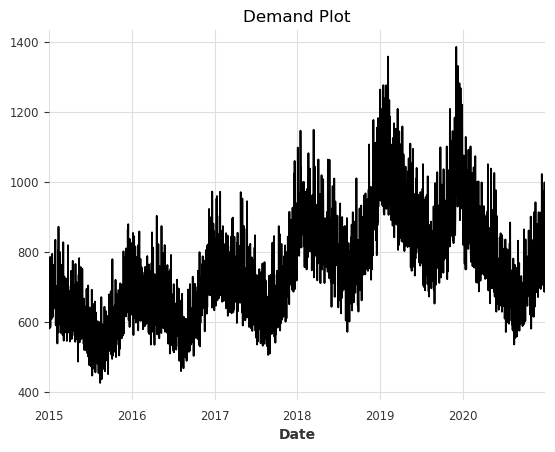

In [8]:
df['y'].plot(title = 'Demand Plot')
plt.show()

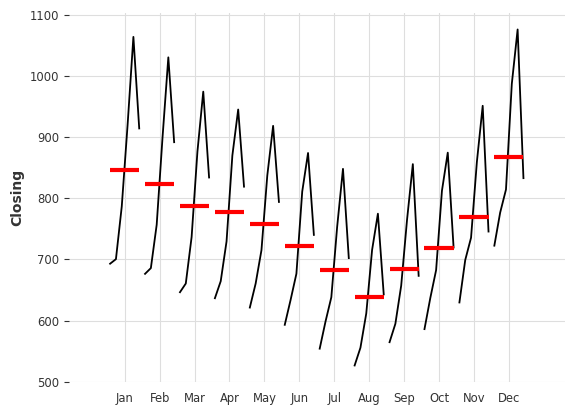

In [9]:
#Plotting the monthly Seasonality
month_plot(df['y'].resample('ME').mean(),
          ylabel = 'Closing')
plt.show()

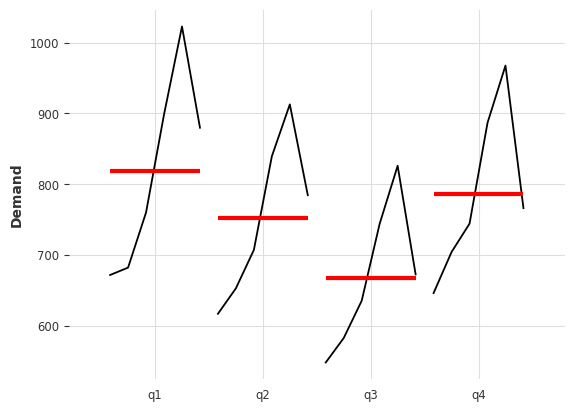

In [10]:
# Plot the quarterly seasonality of the target variable by resampling the data to quarterly frequency and calculating the mean
quarter_plot(df['y'].resample('QE').mean(),
           ylabel = 'Demand')
plt.show()

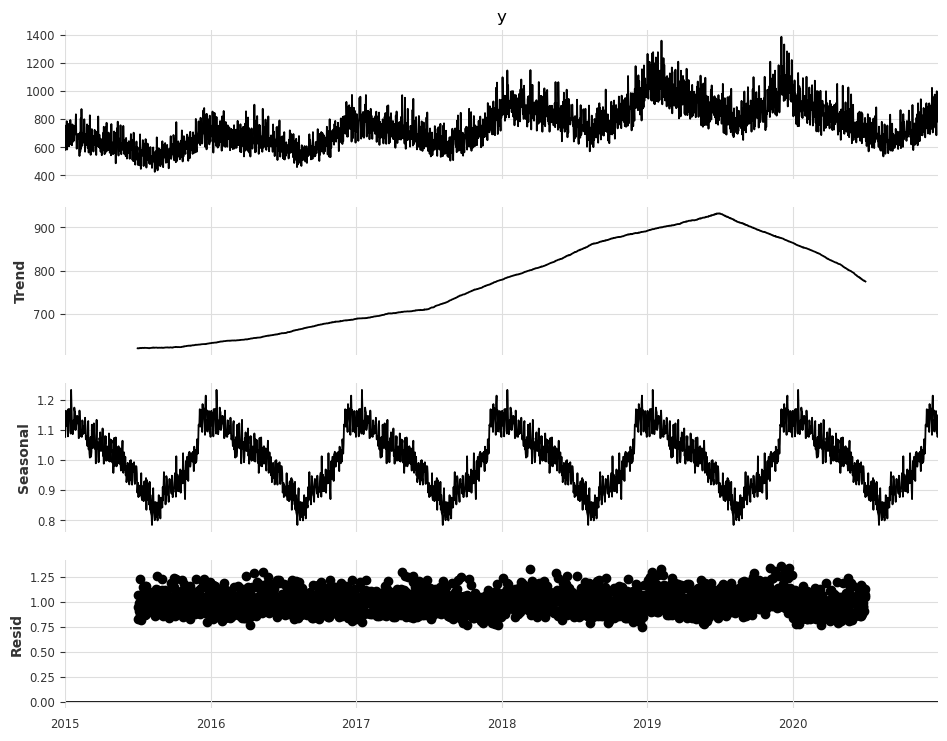

In [11]:
# Perform seasonal decomposition of the daily demand data using an additive model
decomposition = seasonal_decompose(df['y'],
                                   model = 'mul',
                                   period = 365)

# Plot the decomposed components (trend, seasonal, and residual)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

#Prepare for LSTM

In [13]:
#Prepare the time series object
series = TimeSeries.from_series(df.y)
series

<TimeSeries (Date: 2192, component: 1, sample: 1)>
array([[[720.0008852]],

       [[581.2767734]],

       [[754.117039 ]],

       ...,

       [[847.1233994]],

       [[857.5210429]],

       [[783.8914943]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2015-01-01 2015-01-02 ... 2020-12-31
  * component  (component) object 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [14]:
covariates = TimeSeries.from_dataframe(df.iloc[:,:1])
covariates

<TimeSeries (Date: 2192, component: 1, sample: 1)>
array([[[720.0008852]],

       [[581.2767734]],

       [[754.117039 ]],

       ...,

       [[847.1233994]],

       [[857.5210429]],

       [[783.8914943]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2015-01-01 2015-01-02 ... 2020-12-31
  * component  (component) object 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [15]:
series.start_time()

Timestamp('2015-01-01 00:00:00')

In [16]:
# Create time series instances

# Year
year_series = datetime_attribute_timeseries(
    pd.date_range(start = series.start_time(),
                  freq = series.freq_str,
                  periods = df.shape[0]),
                  attribute = "year",
                  one_hot = False)

# Month
month_series = datetime_attribute_timeseries(year_series,
                                             attribute = "month",
                                             one_hot = True)

# Weekday
weekday_series = datetime_attribute_timeseries(year_series,
                                             attribute = "weekday",
                                             one_hot = True)

# Preview
weekday_series

<TimeSeries (time: 2192, component: 7, sample: 1)>
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
...
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2020-12-31
  * component  (component) object 'weekday_0' 'weekday_1' ... 'weekday_6'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [17]:
#Scalling
scaler1 = Scaler()
scaler2 = Scaler()

In [18]:
#Apply scaling for time series
y_transformed = scaler1.fit_transform(series)


In [19]:
# Scale the covariates with additional datetime attributes

# Stack the year_series attribute with the covariates
covariates = covariates.stack(year_series)
# Apply scaling to the covariates
covariates_transformed = scaler2.fit_transform(covariates)
# Stack the month_series attribute with the already scaled covariates
covariates_transformed = covariates_transformed.stack(month_series)
# Stack the weekday_series attribute with the already scaled covariates
covariates_transformed = covariates_transformed.stack(weekday_series)

# Display
covariates_transformed

<TimeSeries (Date: 2192, component: 21, sample: 1)>
array([[[0.30676194],
        [0.        ],
        [1.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.16212707],
        [0.        ],
        [1.        ],
        ...,
        [1.        ],
        [0.        ],
        [0.        ]],

       [[0.34233172],
        [0.        ],
        [1.        ],
        ...,
...
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.45014157],
        [1.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.37337481],
        [1.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2015-01-01 2015-01-02 ... 2020-12-31
  * component  (component) object 'y' 'year' ... 'weekday_5' 'weekday_6'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

#LSTM  Model

In [21]:
forecasting_horizon = 31  # Number of periods to forecast into the future
input_chunk_length = 46  # Number of past periods used for making predictions

training_length = forecasting_horizon + input_chunk_length  # Total length of the training windowforecasting_horizon = 31  # Number of periods to forecast into the future
input_chunk_length = 46  # Number of past periods used for making predictions

training_length = forecasting_horizon + input_chunk_length  # Total length of the training window

In [22]:
# Initialize the LSTM model with specified parameters
model = RNNModel(model = "LSTM",                        # Specify LSTM as the type of RNN model
                 hidden_dim = 20,                       # Set the number of hidden units in LSTM layers
                 n_rnn_layers = 2,                      # Define the number of RNN layers
                 dropout = 0.1,                         # Set dropout rate for regularization
                 n_epochs = 10,                         # Define the number of training epochs
                 optimizer_kwargs = {"lr": 0.003},      # Specify learning rate for the optimizer
                 random_state = 1502,                   # Set random seed for reproducibility
                 training_length = training_length,     # Set the length of the training data
                 input_chunk_length = input_chunk_length,     # Set the length of input chunks for the model
                 pl_trainer_kwargs = {"accelerator": "cpu"}   # Specify training on CPU
                 # pl_trainer_kwargs = {"accelerator": "gpu",
                 #                      "devices": [0]}
                 )

# Fit the model with transformed target data and covariates
model.fit(y_transformed, future_covariates = covariates_transformed)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
C:\Users\titvi\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=2, dropout=0.1, training_length=77, n_epochs=10, optimizer_kwargs={'lr': 0.003}, random_state=1502, input_chunk_length=46, pl_trainer_kwargs={'accelerator': 'cpu'})

#Cross_Validation

In [24]:
# Perform cross-validation with a rolling forecasting window
cv = model.historical_forecasts(series = y_transformed,       # Provide the transformed time series data
                                future_covariates = covariates_transformed, # Provide the transformed covariates
                                start = df.shape[0] - 180,    # Set the starting point for forecasting window
                                forecast_horizon = forecasting_horizon, # Define the number of time steps to forecast ahead
                                stride = 16,                 # Set the stride (step size) for rolling window
                                retrain = True,              # Specify whether to retrain the model at each step
                                last_points_only = False)    # Specify whether to use only the last points for validation

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
---------------------------------------------

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [51]:
# Initialize a list to store RMSE values for cross-validation
rmse_cv = []

# Iterate over each forecast result from cross-validation
for i in range(len(cv)):

  # Convert the forecasted values back to the original scale
  predictions = TimeSeries.to_series(scaler1.inverse_transform(cv[i]))

  # Determine the range of dates for actual values
  start = predictions.index.min()
  end = predictions.index.max()

  # Extract the actual values from the original dataset
  actuals = df.y[start:end,]

  # Calculate the RMSE for the current cross-validation fold
  error_cv = np.sqrt(mean_squared_error(actuals, predictions))
  # Append the RMSE to the list
  rmse_cv.append(error_cv)

# Print the mean RMSE across all cross-validation folds
print(np.mean(rmse_cv))

16.11086718381233


#Parameter Tuning

In [49]:
# Define the parameter grid for tuning
param_grid = { 'n_rnn_layers':[1,2],
               'hidden_dim':[10,20],
               'dropout':[0.1,0.2],
               'n_epochs':[5,10],
               'lr':[0.003],
               'training_length':[77],
               'input_chunk_length':[46]} 
# Generate all combinations of the parameters
grid = ParameterGrid(param_grid)

# Get the total number of parameter combinations
len(list(grid))

16

In [57]:
# Initialize a list to store RMSE values for each parameter combination
rmse = []

# Iterate over each parameter combination in the grid
for params in grid:
  # Build the LSTM model with the current set of parameters
  model = RNNModel(model = "LSTM",
                  hidden_dim = params['hidden_dim'],                   # Set the number of hidden units
                  n_rnn_layers = params['n_rnn_layers'],               # Set the number of RNN layers
                  dropout = params['dropout'],                         # Set the dropout rate
                  n_epochs = params['n_epochs'],                       # Set the number of training epochs
                  optimizer_kwargs = {"lr": params['lr']},             # Set the learning rate
                  random_state = 1502,                                 # Set random seed for reproducibility
                  training_length = params['training_length'],         # Set the training length
                  input_chunk_length = params['input_chunk_length'],   # Set the length of input chunks
                  pl_trainer_kwargs = {"accelerator": "cpu"}           # Specify training on CPU
                  # pl_trainer_kwargs = {"accelerator": "gpu",
                  #                      "devices": [0]}
                  )

  # Fit the model with the transformed data and covariates
  model.fit(y_transformed, future_covariates = covariates_transformed)

  # Perform cross-validation with a rolling forecasting window
  cv = model.historical_forecasts(series = y_transformed,
                                    future_covariates = covariates_transformed,
                                    start = df.shape[0] - 180,          # Set the start point for the forecasting window
                                    forecast_horizon = forecasting_horizon, # Define the forecast horizon
                                    stride = 16,                       # Set the stride for rolling window
                                    retrain = True,                    # Specify to retrain the model at each step
                                    last_points_only = False)          # Specify whether to use only the last points

  # Initialize a list to store RMSE values for cross-validation
  rmse_cv = []

  # Iterate over each forecast result from cross-validation
  for i in range(len(cv)):

    # Convert forecasted values back to the original scale
    predictions = TimeSeries.to_series(scaler1.inverse_transform(cv[i]))

    # Determine the range of dates for actual values
    start = predictions.index.min()
    end = predictions.index.max()

    # Extract the actual values from the original dataset
    actuals = df.y[start:end,]

    # Calculate the RMSE for the current cross-validation fold
    error_cv = np.sqrt(mean_squared_error(actuals, predictions))
    # Append the RMSE to the list
    rmse_cv.append(error_cv)


  # Calculate and store the mean RMSE for the current parameter combination
  error = np.mean(rmse_cv)
  rmse.append(error)

C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | trai

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion  

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | tra

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | trai

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion  

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | tra

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | trai

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion  

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.4 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | tra

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.2 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | trai

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V             

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion  

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 K  | train
6 | V            

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | tra

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [59]:
# Create a DataFrame and add the RMSE values
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,dropout,hidden_dim,input_chunk_length,lr,n_epochs,n_rnn_layers,training_length,rmse
0,0.1,10,46,0.003,5,1,77,67.887122
1,0.1,10,46,0.003,5,2,77,68.535682
2,0.1,10,46,0.003,10,1,77,29.635347
3,0.1,10,46,0.003,10,2,77,44.513269
4,0.1,20,46,0.003,5,1,77,75.541155
5,0.1,20,46,0.003,5,2,77,54.022359
6,0.1,20,46,0.003,10,1,77,34.056971
7,0.1,20,46,0.003,10,2,77,16.110867
8,0.2,10,46,0.003,5,1,77,67.887122
9,0.2,10,46,0.003,5,2,77,70.770146


In [61]:
# Identify the parameter set(s) with the lowest RMSE and export it to a CSV file
best_params = tuning_results[tuning_results['rmse'] == tuning_results['rmse'].min()]
best_params = best_params.iloc[0,:]
best_params.to_csv("best_params_round01.csv")

Parameter Round 2

In [64]:
# Load the best parameters from the CSV file
params_round1 = pd.read_csv("best_params_round01.csv", index_col = 0)
params_round1

,7
dropout,0.100000
hidden_dim,20.000000
input_chunk_length,46.000000
lr,0.003000
n_epochs,10.000000
n_rnn_layers,2.000000
training_length,77.000000
rmse,16.110867


In [68]:
# Isolate and convert the three parameters from the best parameter set
n_rnn_layers = int(params_round1.loc["n_rnn_layers"].iloc[0])  # Extract and convert the number of RNN layers
hidden_dim = int(params_round1.loc["hidden_dim"].iloc[0])      # Extract and convert the number of hidden units
dropout = params_round1.loc["dropout"].iloc[0]                 # Extract the dropout rate
dropout  # Display the dropout rate

0.1

In [70]:
# Define the parameter grid for tuning
param_grid = {'n_rnn_layers': [n_rnn_layers],
              'hidden_dim': [hidden_dim],
              'dropout': [dropout],
              'n_epochs': [5, 10],
              'lr': [0.003, 0.01],
              'training_length': [60, 77],
              'input_chunk_length': [35, 46]}

# Generate all combinations of the parameters
grid = ParameterGrid(param_grid)
# Get the total number of parameter combinations
len(list(grid))

16

In [76]:
# Initialize a list to store RMSE values for each parameter combination
rmse = []

# Iterate over each parameter combination in the grid
for params in grid:
  # Build the LSTM model with the current set of parameters
  model = RNNModel(model = "LSTM",
                  hidden_dim = params['hidden_dim'],                  # Set the number of hidden units
                  n_rnn_layers = params['n_rnn_layers'],              # Set the number of RNN layers
                  dropout = params['dropout'],                        # Set the dropout rate
                  n_epochs = params['n_epochs'],                      # Set the number of training epochs
                  optimizer_kwargs = {"lr": params['lr']},            # Set the learning rate
                  random_state = 1502,                                # Set random seed for reproducibility
                  training_length = params['training_length'],        # Set the training length
                  input_chunk_length = params['input_chunk_length'],  # Set the length of input chunks
                 pl_trainer_kwargs = {"accelerator": "cpu"}
                  # pl_trainer_kwargs = {"accelerator": "gpu",
                  #                      "devices": [0]}                # Specify training on GPU
                  )

  # Fit the model with the transformed data and covariates
  model.fit(y_transformed, future_covariates = covariates_transformed)

  # Perform cross-validation with a rolling forecasting window
  cv = model.historical_forecasts(series = y_transformed,
                                  future_covariates = covariates_transformed,
                                  start = df.shape[0] - 180,          # Set the start point for the forecasting window
                                  forecast_horizon = forecasting_horizon, # Define the forecast horizon
                                  stride = 16,                       # Set the stride for rolling window
                                  retrain = True,                    # Specify to retrain the model at each step
                                  last_points_only = False)          # Specify whether to use only the last points

  # Initialize a list to store RMSE values for cross-validation
  rmse_cv = []

  # Iterate over each forecast result from cross-validation
  for i in range(len(cv)):

    # Convert forecasted values back to the original scale
    predictions = TimeSeries.to_series(scaler1.inverse_transform(cv[i]))

    # Determine the range of dates for actual values
    start = predictions.index.min()
    end = predictions.index.max()

    # Extract the actual values from the original dataset
    actuals = df.y[start:end,]

    # Calculate the RMSE for the current cross-validation fold
    error_cv = np.sqrt(mean_squared_error(actuals, predictions))
    # Append the RMSE to the list
    rmse_cv.append(error_cv)


  # Calculate and store the mean RMSE for the current parameter combination
  error = np.mean(rmse_cv)
  rmse.append(error)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
C:\Users\titvi\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | trai

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | trai

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | tra

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | tra

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | trai

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | trai

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | tra

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | tra

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | trai

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | trai

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | tra

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | tra

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | trai

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | trai

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train m

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | tra

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | tra

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 6.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
7         Modules in train 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [81]:
# Retrieve the best params and put in in a dataframe
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,dropout,hidden_dim,input_chunk_length,lr,n_epochs,n_rnn_layers,training_length,rmse
0,0.1,20,35,0.003,5,2,60,51.659084
1,0.1,20,35,0.003,5,2,77,54.022354
2,0.1,20,35,0.003,10,2,60,16.176559
3,0.1,20,35,0.003,10,2,77,16.110903
4,0.1,20,35,0.010,5,2,60,15.101969
5,0.1,20,35,0.010,5,2,77,18.084820
6,0.1,20,35,0.010,10,2,60,8.833731
7,0.1,20,35,0.010,10,2,77,10.769460
8,0.1,20,46,0.003,5,2,60,51.659087
9,0.1,20,46,0.003,5,2,77,54.022359


In [85]:
# Identify the parameter set(s) with the lowest RMSE and export it to a CSV file
best_params = tuning_results[tuning_results['rmse'] == tuning_results['rmse'].min()]
best_params = best_params.iloc[0,:]
best_params.to_csv("best_params_round02.csv")

Predict the future

In [88]:
# Load the best parameters from the CSV file
params_round2 = pd.read_csv("best_params_round2.csv", index_col = 0)
params_round2

,6
dropout,0.100000
hidden_dim,20.000000
input_chunk_length,35.000000
lr,0.010000
n_epochs,10.000000
n_rnn_layers,2.000000
training_length,60.000000
rmse,8.833731


In [90]:
# Isolate and convert all parameters from the best parameter set

n_rnn_layers = int(params_round2.loc["n_rnn_layers"].iloc[0])
hidden_dim = int(params_round2.loc["hidden_dim"].iloc[0])
dropout = params_round2.loc["dropout"].iloc[0]
input_chunk_length = int(params_round2.loc["input_chunk_length"].iloc[0])
lr = params_round2.loc["lr"].iloc[0]
n_epochs = int(params_round2.loc["n_epochs"].iloc[0])
training_length = int(params_round2.loc["training_length"].iloc[0])

In [92]:
# Load the future covariates from a CSV file, setting the 'Date' column as the index and parsing dates
future_df = pd.read_csv("future.csv", index_col = "Date", parse_dates = True)
future_df.head()

,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
Date,,,,,,
2021-01-01,NaN,0,0,0,5.00,154.221
2021-01-02,NaN,0,0,0,11.11,264.805
2021-01-03,NaN,0,0,0,3.89,115.499
2021-01-04,NaN,0,0,0,6.67,124.650
2021-01-05,NaN,0,0,0,5.56,77.968


In [94]:
# Extract the regressors for training and future data
X_train = df.iloc[:,1:]
X_future = future_df.iloc[:,1:]

# Combine the training and future regressors into a single DataFrame
X = pd.concat([X_train, X_future])

In [96]:
# Convert the combined regressors DataFrame into TimeSeries objects
covariates = TimeSeries.from_dataframe(X)

In [98]:
# Create a TimeSeries instances

# Year
year_series = datetime_attribute_timeseries(
    pd.date_range(start = series.start_time(),
                  freq = series.freq_str,
                  periods = X.shape[0]),
                  attribute = "year",
                  one_hot = False)
# Month
month_series = datetime_attribute_timeseries(year_series,
                                             attribute = "month",
                                             one_hot = True)

# Weekday
weekday_series = datetime_attribute_timeseries(year_series,
                                             attribute = "weekday",
                                             one_hot = True)

# Preview
weekday_series

<TimeSeries (time: 2223, component: 7, sample: 1)>
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
...
        ...,
        [1.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]]])
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2021-01-31
  * component  (component) object 'weekday_0' 'weekday_1' ... 'weekday_6'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [100]:
# Import the Scaler class and initialize two instances of it
scaler1 = Scaler()
scaler2 = Scaler()

In [102]:
# Apply the scaler to the time series
y_transformed = scaler1.fit_transform(series)

In [104]:
# Scale the covariates with additional datetime attributes

# Stack the year_series attribute with the covariates
covariates = covariates.stack(year_series)
# Apply scaling to the covariates
covariates_transformed = scaler2.fit_transform(covariates)
# Stack the month_series attribute with the already scaled covariates
covariates_transformed = covariates_transformed.stack(month_series)
# Stack the weekday_series attribute with the already scaled covariates
covariates_transformed = covariates_transformed.stack(weekday_series)

# Display
covariates_transformed

<TimeSeries (Date: 2223, component: 25, sample: 1)>
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
...
        ...,
        [1.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2015-01-01 2015-01-02 ... 2021-01-31
  * component  (component) object 'Easter' 'Thanksgiving' ... 'weekday_6'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [108]:
# LSTM model



# Initialize the LSTM model with the specified parameters
model = RNNModel(model = "LSTM",
                 hidden_dim = hidden_dim,                      # Set the number of hidden units
                 n_rnn_layers = n_rnn_layers,                  # Set the number of RNN layers
                 dropout = dropout,                            # Set the dropout rate
                 n_epochs = n_epochs,                          # Set the number of training epochs
                 optimizer_kwargs = {"lr": lr},                # Set the learning rate for the optimizer
                 random_state = 1502,                          # Set random seed for reproducibility
                 training_length = training_length,            # Set the training length
                 input_chunk_length = input_chunk_length,      # Set the length of input chunks
                  pl_trainer_kwargs = {"accelerator": "cpu"}
                 # pl_trainer_kwargs = {"accelerator": "gpu",    # Use GPU for training
                 #                     "devices": [0]}
                 )

# Fit the model with the transformed target data and covariates
model.fit(y_transformed, future_covariates = covariates_transformed)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
C:\Users\titvi\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=2, dropout=0.1, training_length=60, n_epochs=10, optimizer_kwargs={'lr': 0.01}, random_state=1502, input_chunk_length=35, pl_trainer_kwargs={'accelerator': 'cpu'})

In [112]:
# Predict future values using the trained model
predictions = model.predict(n = len(future_df),               # Predict for the length of the future data
                            future_covariates = covariates_transformed) # Use transformed covariates for prediction

# Convert predictions back to the original scale and create a pandas Series with the name "LSTM"
predictions = TimeSeries.to_series(
    scaler1.inverse_transform(predictions)).rename("LSTM")

# Display the predictions
predictions

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\titvi\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting: |                                                                                    | 0/? [00:00<…

Date
2021-01-01    768.637986
2021-01-02    898.302074
2021-01-03    790.173036
2021-01-04    955.893479
2021-01-05    795.228105
2021-01-06    963.059765
2021-01-07    847.353627
2021-01-08    762.662775
2021-01-09    906.469892
2021-01-10    800.110930
2021-01-11    974.106380
2021-01-12    797.062406
2021-01-13    962.030564
2021-01-14    849.709591
2021-01-15    764.149241
2021-01-16    907.069882
2021-01-17    800.574532
2021-01-18    943.536576
2021-01-19    796.193023
2021-01-20    974.327450
2021-01-21    855.586081
2021-01-22    759.448655
2021-01-23    910.532841
2021-01-24    822.603364
2021-01-25    963.070234
2021-01-26    806.335725
2021-01-27    956.000237
2021-01-28    851.583736
2021-01-29    763.189243
2021-01-30    908.116880
2021-01-31    801.086657
Freq: D, Name: LSTM, dtype: float64

In [116]:
# Function to plot training data and future forecasts
def plot_future(y, forecast, title):
  plt.figure(figsize = (10,4))
  plt.plot(y, label = 'Train')  # Plot the training data
  plt.plot(forecast, label = "Forecast")  # Plot the forecasted data
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

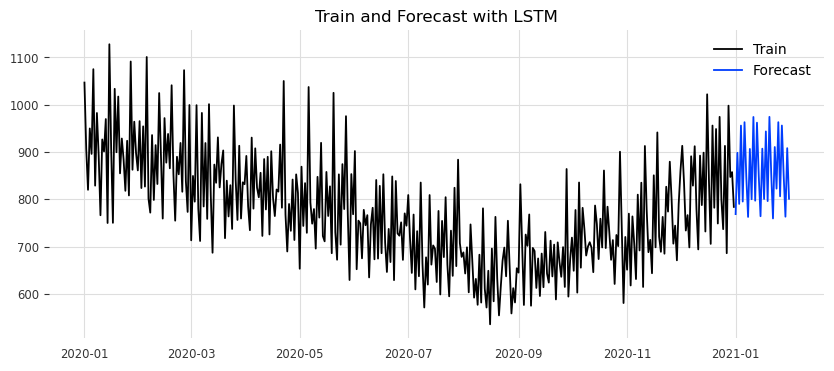

In [118]:
# Plot the training data from 2020 and the LSTM forecast
plot_future(df.y['2020':], predictions, "LSTM")